# Modeling

## 0. Importing libraries and data

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
from scipy.stats import boxcox
pd.options.display.max_rows = 50
pd.options.display.max_columns = 999

In [2]:
from helper_functions import import_dataset, rf_model, rf_clustering, evaluate

In [13]:

rs = import_dataset()

In [14]:
rs.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
count,17791.000000,17791.000000,17791.000000,17791.000000,17791.00000,17791.000000,17791.000000,17791.000000,17791.000000,17791.000000,17791.000000,17791.000000,17791.000000,17791.000000,17791.000000,17791.000000,17791.000000,1.779100e+04
mean,3.327975,2.065005,1953.219886,6874.427857,1.49896,0.002586,0.079366,3.420381,7.540610,0.394357,1970.442640,0.059412,98081.961778,47.563729,-122.230332,1887.092575,6834.770558,5.024093e+05
std,0.861364,0.719877,764.858799,3031.181545,0.54835,0.050784,0.270317,0.639129,1.028225,0.488726,30.438956,0.312041,53.763046,0.136010,0.131126,604.214402,2827.610698,2.826141e+05
min,1.000000,1.000000,390.000000,520.000000,1.00000,0.000000,0.000000,3.000000,4.000000,0.000000,1900.000000,0.000000,98001.000000,47.189500,-122.475000,620.000000,651.000000,8.200000e+04
25%,3.000000,1.500000,1380.000000,4760.000000,1.00000,0.000000,0.000000,3.000000,7.000000,0.000000,1950.000000,0.000000,98034.000000,47.483050,-122.337000,1450.000000,4844.000000,3.150000e+05
50%,3.000000,2.250000,1830.000000,7000.000000,1.50000,0.000000,0.000000,3.000000,7.000000,0.000000,1973.000000,0.000000,98074.000000,47.575400,-122.269000,1760.000000,7052.000000,4.350000e+05
75%,4.000000,2.500000,2400.000000,8893.000000,2.00000,0.000000,0.000000,4.000000,8.000000,1.000000,1999.000000,0.000000,98118.000000,47.679500,-122.154000,2220.000000,8660.500000,6.120000e+05
max,6.000000,5.250000,4980.000000,14986.000000,3.50000,1.000000,1.000000,5.000000,12.000000,1.000000,2015.000000,2.000000,98199.000000,47.777600,-121.315000,4950.000000,14960.000000,3.400000e+06


## 1. Regression plots

### We start with plotting every variable against the price.
 It's a simple visualization that will allow us to check how each variable (except the date) is related (or not) to the price.

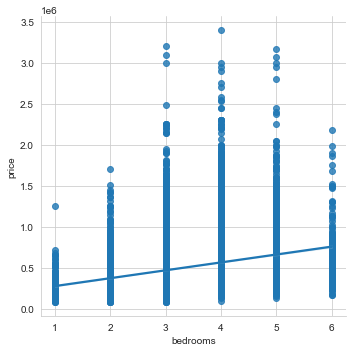

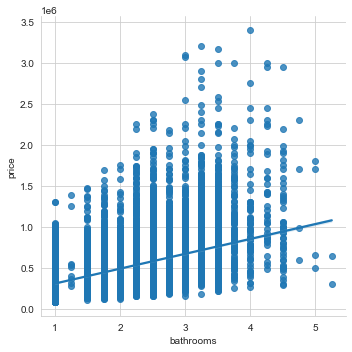

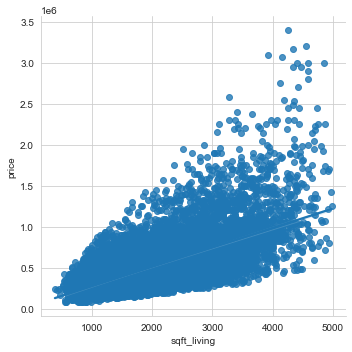

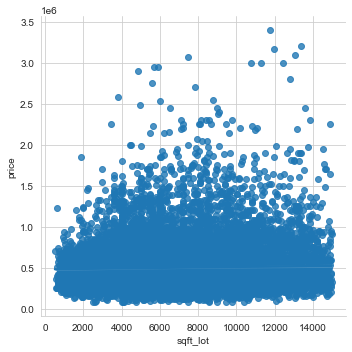

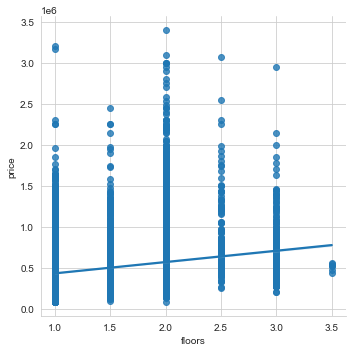

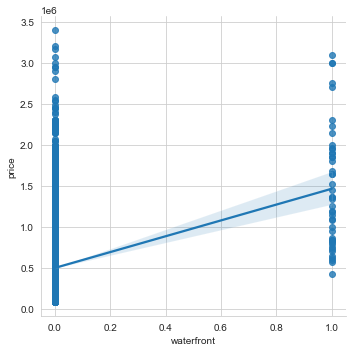

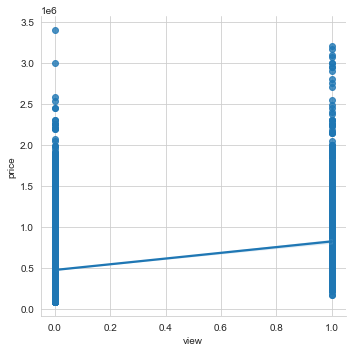

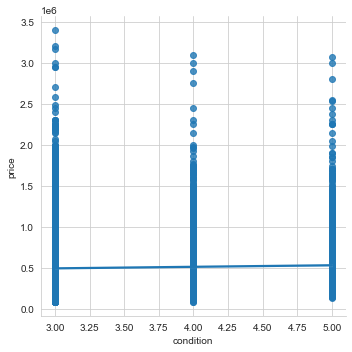

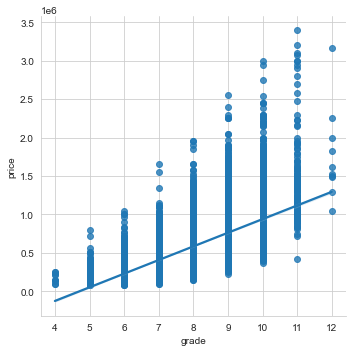

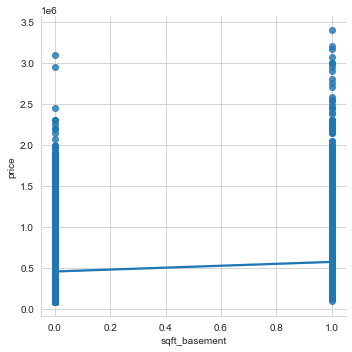

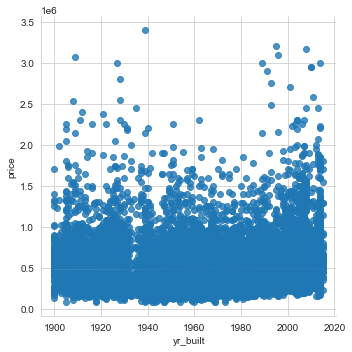

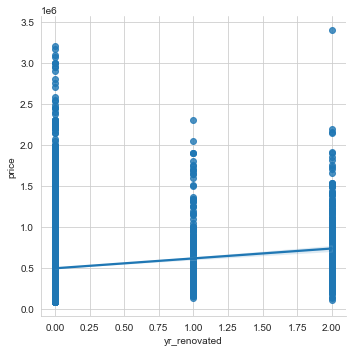

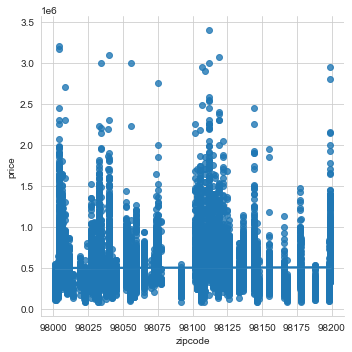

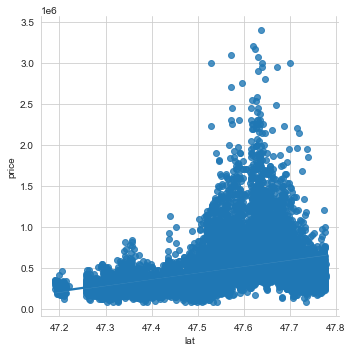

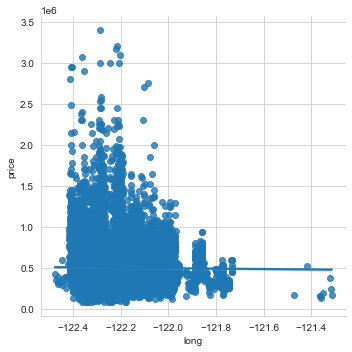

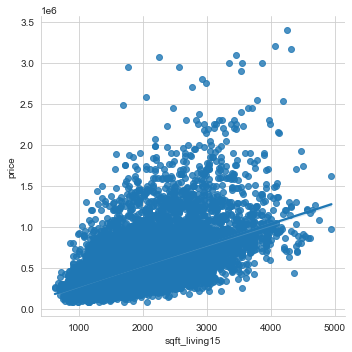

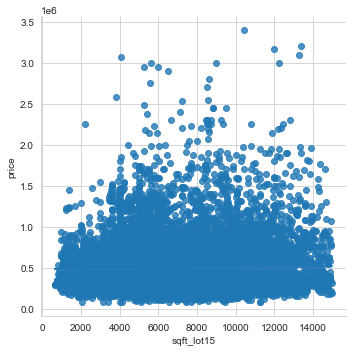

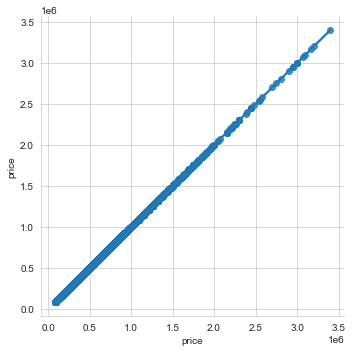

In [15]:
sns.set_style('whitegrid')

for col in rs.columns:
        if col == "date":
            continue
        sns.lmplot(x = col, y ='price', data = rs)

Interesting columns:
- Bedrooms: normal distribution, positive correlation
- Bathrooms: similar
- Sqft living: positive correlation, possibly exponential
- Waterfront: strong correlation for this "boolean" variable.
- View: interesting correlation
- Grade: extremely strong correlation
- Sqft above: very strong correlation and good data distribution
- Sqft living 15: maybe we could eliminate this one or the sqft living one, if they are closely related.


Weaker correlations:
- Sqft lot and sqft lot 15: there is a slight positive correlation but quite weak.
- Floors: same thing as sqft lot.
- Sqft basement: it practically does not affect the price
- Yr renovated: weak correlation.

Location and zipcode: it would be interesting to do a clustering exercise to see if we can convert them into more useful information for a regression.

Non-interesting columns:
- Condition: practically no correlation.
- Yr built: from the data it is very likely that we will not obtain any useful information from this column.


Let's see the heatmap in order to check the correlations between all the variables, including the price

In [6]:
# We don't want the date, or the location and zipcode.
heat_df = rs.drop(["zipcode", "lat", "long"], axis=1)


<AxesSubplot:>

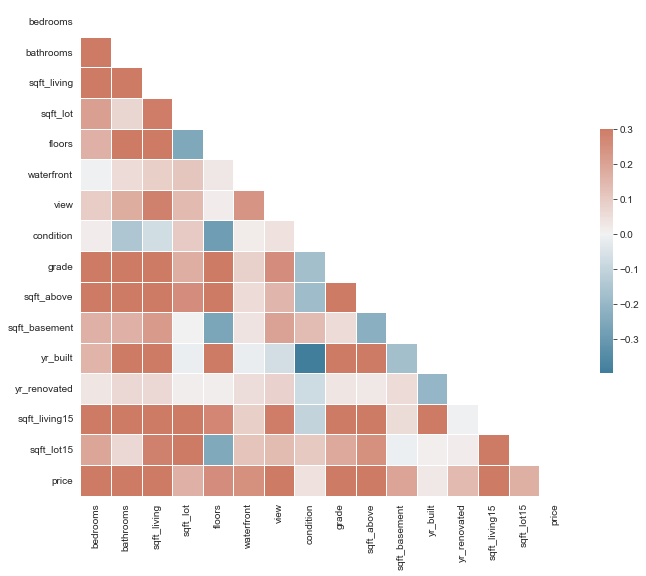

In [7]:
corr = heat_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### The conclusions from the heatmap are interesting: the columns we saw as less interesting have weaker or negative correlations with the price. We will have experiment with three datasets:
1. A full dataset except the date, so including location.
2. A "weak" dataset which will have all the columns except: date, location information, year built and condition. 
3. A "strong" dataset with only the columns where we have observed the best correlations:Bedrooms,Bathrooms, Sqft living, Waterfront, View, Grade, Sqft above, sqft living 15.

In [16]:
full = rs
weak = full.drop(["zipcode", "lat", "long", "yr_built", "condition"], axis=1)
strong = weak.drop(["sqft_lot", "sqft_lot15", "floors", "sqft_basement", "yr_renovated"], axis=1)
strong2 = full.drop(["yr_built", "condition"], axis=1)

# Modeling

In [17]:
X_train, X_test, y_train, y_test = train_test_split(rs.drop("price",axis=1), rs["price"], random_state=1)


In [19]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13343 entries, 4181 to 292
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       13343 non-null  int64  
 1   bathrooms      13343 non-null  float64
 2   sqft_living    13343 non-null  int64  
 3   sqft_lot       13343 non-null  int64  
 4   floors         13343 non-null  float64
 5   waterfront     13343 non-null  int64  
 6   view           13343 non-null  int64  
 7   condition      13343 non-null  int64  
 8   grade          13343 non-null  int64  
 9   sqft_basement  13343 non-null  int64  
 10  yr_built       13343 non-null  int64  
 11  yr_renovated   13343 non-null  int64  
 12  zipcode        13343 non-null  int64  
 13  lat            13343 non-null  float64
 14  long           13343 non-null  float64
 15  sqft_living15  13343 non-null  int64  
 16  sqft_lot15     13343 non-null  int64  
dtypes: float64(4), int64(13)
memory usage: 1.8 MB


## 1. Linear Regression model

We start with a simple linear regression, where we will use a standard scaler. 

Coefficients: 
 [-18697.10266347  15439.07894136 101630.21875725 -12100.02279723
   6392.76895105  31947.59723626  30740.91708164  20945.74683653
 109229.12191513  -2055.98667421 -69985.0261787    9854.62628454
 -20769.87264328  77350.03563139 -14382.08446974  21268.02312795
 -10453.16845788]
Mean squared error: 25469417479.87
Coefficient of determination: 0.69


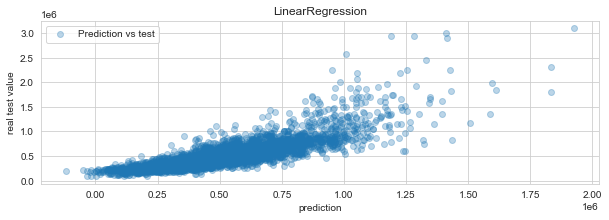

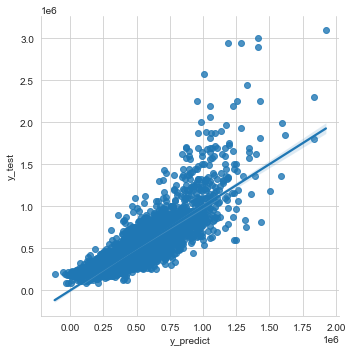

In [18]:
scaler = StandardScaler()
reg = LinearRegression()
pipe = make_pipeline(scaler, reg)
pipe.fit(X_train, y_train)

y_predict = pipe.predict(X_test)

# The coefficients
print('Coefficients: \n', reg.coef_)
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_predict))
#The mean logistic error
#print('Mean squared logistic error: %.2f' % mean_squared_log_error(y_test, y_predict))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test,y_predict))

# Plot outputs
fig, axes = plt.subplots(1, 1, figsize=(10, 3))
axes.scatter(y_predict, y_test, alpha=.3, label='Prediction vs test')
axes.set(xlabel='prediction',
            ylabel='real test value', title='LinearRegression')
axes.legend()

sns.lmplot(x = "y_predict", y = "y_test", data = pd.DataFrame(data={"y_predict":y_predict, "y_test":y_test}))

The results are not very good: the mean squared error is 0.494, and the coefficient of determination is 0.57

## 2. Stochastic Gradient Descent Regression

We are going to try another linear regression, the stochastic gradient descent. We operate in similar fashion:

Coefficients: 
 [-20304.85147905  16352.89874819 102750.66122556 -12767.36585072
   8674.1292509   26966.0929218   28799.0921798   22059.49701738
 111212.89016787  -1006.72395503 -72256.83467536  11552.69238271
 -19957.67296265  80474.5388848  -14174.10529859  23967.63214651
 -11210.85767102]
Mean squared error: 25391677598.25
Coefficient of determination: 0.69


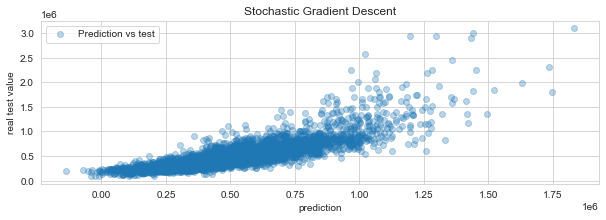

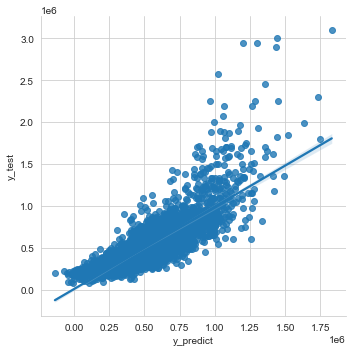

In [23]:
scaler = StandardScaler()
reg = SGDRegressor()
pipe = make_pipeline(scaler, reg)
pipe.fit(X_train, y_train)

y_predict = pipe.predict(X_test)

# The coefficients
print('Coefficients: \n', reg.coef_)
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_predict))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test,y_predict))

# Plot outputs
fig, axes = plt.subplots(1, 1, figsize=(10, 3))
axes.scatter(y_predict, y_test, alpha=.3, label='Prediction vs test')
axes.set(xlabel='prediction',
            ylabel='real test value', title='Stochastic Gradient Descent')
axes.legend()

sns.lmplot(x = "y_predict", y = "y_test", data = pd.DataFrame(data={"y_predict":y_predict, "y_test":y_test}))

### The results are exactly the same as with the linear regression.

## 3. Generalized linear regression

We will try a more complex model of linear regression, to see if we can get better results.

Coefficients: 
 [-0.00787254  0.03116059  0.14123558 -0.01774593  0.00942602  0.02197877
  0.03383423  0.04117616  0.18721409  0.00405441 -0.10263865  0.01016101
 -0.04947551  0.17058902 -0.04920459  0.04831794 -0.03767056]
Mean squared error: 21250440500.90
Coefficient of determination: 0.74


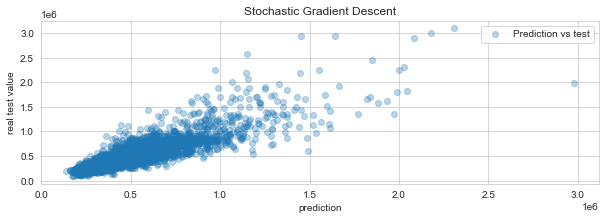

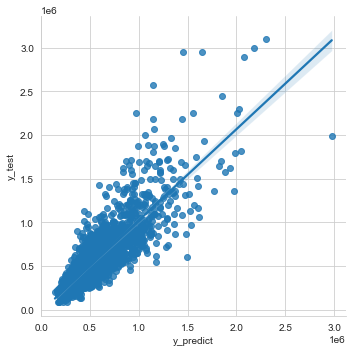

In [24]:
scaler = StandardScaler()
reg = TweedieRegressor(power=0, alpha=0.5, link='log')
pipe = make_pipeline(scaler, reg)
pipe.fit(X_train, y_train)

y_predict = pipe.predict(X_test)

# The coefficients
print('Coefficients: \n', reg.coef_)
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_predict))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test,y_predict))

# Plot outputs
fig, axes = plt.subplots(1, 1, figsize=(10, 3))
axes.scatter(y_predict, y_test, alpha=.3, label='Prediction vs test')
axes.set(xlabel='prediction',
            ylabel='real test value', title='Stochastic Gradient Descent')
axes.legend()

sns.lmplot(x = "y_predict", y = "y_test", data = pd.DataFrame(data={"y_predict":y_predict, "y_test":y_test}))

## The results are getting better: we have a MSE ofof 32% and a coefficient of determination of 0.72% 

We  try with:
- Ridge gets the same results as LinearRegression.
- ElasticNet is much worse.
- RANSAC (RANdom SAmple Consensus) even worse (MSE =72).
- Perceptron very bad results.



## 4. Random Forest Regressor

We now try more complex regression systems. Random Forest seems like a good candidate.

Mean squared error: 10465179592.03
Coefficient of determination: 0.87


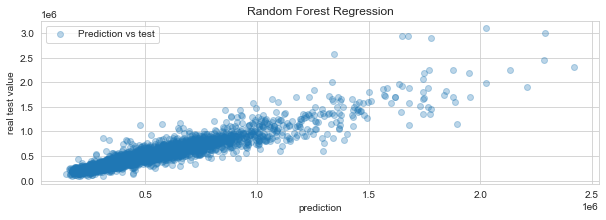

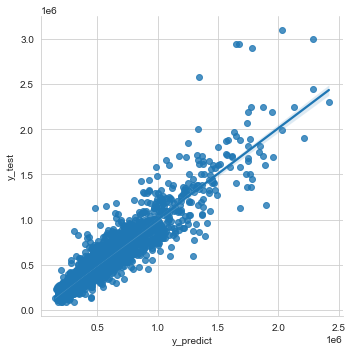

In [22]:
#scaler = StandardScaler()
reg = RandomForestRegressor()
#pipe = make_pipeline(scaler, reg)
reg.fit(X_train, y_train)

y_predict = reg.predict(X_test)

# The coefficients
#print('Coefficients: \n', reg.coef_)
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_predict))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test,y_predict))

# Plot outputs
fig, axes = plt.subplots(1, 1, figsize=(10, 3))
axes.scatter(y_predict, y_test, alpha=.3, label='Prediction vs test')
axes.set(xlabel='prediction',
            ylabel='real test value', title='Random Forest Regression')
axes.legend()

sns.lmplot(x = "y_predict", y = "y_test", data = pd.DataFrame(data={"y_predict":y_predict, "y_test":y_test}))

### So far random forest is the best classifier.
- Full dataset: MSE 16%, coefficient of determination 0.86
- Strong: MSE 45%, coefficient of determination 0.60
- Strong with location: MSE 16%, coefficient of determination 0.86
- Weak: MSE 38.44%, coefficient of determination 0.67

We try modifying our most promising dataset: the strong with location. We drop columns and see the results:
- sqft_lot15: MSE 15.9%
- sqft_lot: MSE 16.2%
- floors: MSE 16.3%
- sqft_basement: MSE 15.9%
- year renovated: 16.4%

So the error doesn't improve perceptible by dropping any of those columns. We will use that matrix from now on. But we will try and add a classification model for the location.
